In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import datetime
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# ensure that all columns are shown and that colum content is not cut
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 500) # ensure that all rows are shown

# Formulas

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [4]:
# Step 1 : target creation + train_test_split
# Creating target variables to automate creation of quarterly, yearly and 2-yearly targets, because well, DON'T REPEAT YOURSELF!
def create_target_variable(df, frequency:int, threshold):
    if frequency == 1:
        col = 'mc_qtr_growth_pct'
    if frequency == 4:
        col = 'mc_yr_growth_pct'
    if frequency == 8:
        col = 'mc_2yr_growth_pct'
   #else:
   #    raise ValueError("Invalid frequency. Use 1 (quarterly), 4 (yearly), or 8 (2-year).")
    df[col] = df[col].shift(-frequency)
    df.dropna(subset=col, inplace=True)
    target_func = lambda x: 1 if ((x[col] > threshold) & (x.small_cap == 1)) else 0
    df['target'] = df.apply(target_func, axis=1)
    return df

# Creating a custom function for the group split
def group_train_test_split(data, test_size=0.2, random_state=None):
    # We split by groups (company ticker) while keeping the data structure intact.
    unique_groups = data['Ticker'].unique()
    train_groups, test_groups = train_test_split(unique_groups, test_size=test_size, random_state=random_state)
    X_train = data[data['Ticker'].isin(train_groups)].drop(['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct'], axis = 1)
    X_test = data[data['Ticker'].isin(test_groups)].drop(['mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct'], axis = 1)
    y_train = data[data['Ticker'].isin(train_groups)]['target']
    y_test = data[data['Ticker'].isin(test_groups)]['target']
    return X_train, X_test, y_train, y_test

In [5]:
# Step 2: Identify numerical and categorical features
def identify_feature_types(df):
    """Identifies the numerical and categorical columns in the DataFrame."""
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Exclude 'Ticker' from categorical features as it's not needed for transformation
    if 'target' in numerical_features:
        numerical_features.remove('target')
    if 'cik' in numerical_features:
        numerical_features.remove('cik')
    if 'TICKER' in categorical_features:
        categorical_features.remove('TICKER')
    if 'quarter' in categorical_features:
        categorical_features.remove('quarter')

    return numerical_features, categorical_features

In [6]:
# Step 3: Create preprocessing pipeline for numerical and categorical features
def create_preprocessing_pipeline(numerical_features, categorical_features):
    """Creates the preprocessing pipeline for numerical and categorical features."""
    # Preprocessing for numerical data: RobustScaler to make our numbers más robusto.
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # Handle NaNs
        ('scaler', RobustScaler())  # Scale the data
    ])

    # Preprocessing for categorical data: OneHotEncoder to give each category its own columm...
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categories
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Encode categories
    ])

    # Combine the transformers into one big ColumnTransformer.
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    return preprocessor

In [7]:
# Step 4: Function to preprocess data in training mode (fitting the pipeline)
def preprocess_training_data(X_train, preprocessor=None):
    """Fits and transforms the training data using the provided pipeline."""
    if preprocessor is None:
        # Identify feature types
        numerical_features, categorical_features = identify_feature_types(X_train)
        preprocessor = create_preprocessing_pipeline(numerical_features, categorical_features)

    # Fit and transform the training data
    X_train_processed = preprocessor.fit_transform(X_train)
    return X_train_processed, preprocessor

In [8]:
# Step 5: Function to preprocess new/unseen/test data in production mode (only transforming)
def preprocess_new_data(X_new, preprocessor):
    """Transforms new/unseen/test data using a pre-fitted pipeline."""
    if preprocessor is None:
        raise ValueError("The preprocessor must be fitted on training data first before transforming new data.")

    # Transform the new data (no fitting here)
    X_new_processed = preprocessor.transform(X_new)
    return X_new_processed

In [9]:
# Step 6: Function to predict based on different target inputs defined at the create_target_variable stage: quarterly (frequency=1), yearly (frequency=4), and 2-year (frequency=8) predictions
def train_logistic_regression(X_train, y_train, X_test, y_test):
    """ Trains and evaluates a logistic regression model, and returns multiple evaluation metrics
    (accuracy, precision, recall, F1-score) using cross-validation and test data.
    """
    # Train logistic regression model with a progress bar
    logistic_model = LogisticRegression(solver='saga', max_iter=5000)

    # Display progress during model fitting
    with tqdm(total=100, desc="Training Logistic Regression", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
        logistic_model.fit(X_train, y_train)
        pbar.update(100)  # Update the progress bar after training completes

    # Check number of iterations
    print(f"Number of iterations: {logistic_model.n_iter_}")

    # Evaluate using cross-validation for accuracy, precision, recall, and F1-score with progress
    cv_metrics = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        with tqdm(total=5, desc=f"Cross-Validation ({metric})", bar_format='{l_bar}{bar} [elapsed: {elapsed} left: {remaining}]') as pbar:
            cv_metrics[metric] = cross_val_score(logistic_model, X_train, y_train, cv=5, scoring=metric)
            pbar.update(5)

    # Print cross-validation scores
    print(f"Cross-validated Metrics: {', '.join([f'{m}: {cv_metrics[m].mean():.4f}' for m in cv_metrics])}")

    # Test on the test set
    y_pred_test = logistic_model.predict(X_test)

    # Calculate test set metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred_test),
        'precision': precision_score(y_test, y_pred_test),
        'recall': recall_score(y_test, y_pred_test),
        'f1': f1_score(y_test, y_pred_test)
    }

    # Create a dictionary to store all metrics
    metrics = {**{f'cv_{m}': cv_metrics[m].mean() for m in cv_metrics}, **test_metrics}

    return metrics, logistic_model

# Modeling

In [10]:
# Data

df = pd.read_csv('../raw_data/data_for_preprocessing.csv', index_col=0)
df.shape

(170124, 59)

In [11]:
# Parameters
threshold = 0.5
small_cap = True
quarters_input = 4
model_type = 'classifier'
horizon = 'year'

if horizon == 'quarter':
    col = 'mc_qtr_growth_pct'
    adjustment = 0
elif horizon == 'year':
    col = 'mc_yr_growth_pct'
    adjustment = 3
elif horizon == 'year':
    col = 'mc_2yr_growth_pct'
    adjustment = 7
    
if model_type == 'classifier':
    final_activation = 'sigmoid'
    metrics=['accuracy', 'precision', 'recall']
else:
    final_activation = 'linear'
    metrics=['r2', 'mse', 'mae']

In [12]:
if small_cap==True:
    target_func = lambda x: 1 if ((x[col] > threshold) & (x.small_cap == 1)) else 0
else:
    target_func = lambda x: 1 if ((x[col] > threshold)) else 0
    
if model_type == 'classifier':
    df['target'] = df.apply(target_func, axis=1)
else:
    df['target'] = df[col]

unique_groups = df['TICKER'].unique()
train_groups, test_groups = train_test_split(unique_groups, test_size=0.3, random_state=42)

data_train = df[df['TICKER'].isin(train_groups)]
data_test = df[df['TICKER'].isin(test_groups)]

# data_train[data_train.target==1].head()

In [13]:
#y_set = df.iloc[:, -11:]

# Year-ahead
#y_tar = y_set.groupby(['CIK', 'TICKER'], as_index=False)[['CIK', 'TICKER', 'mc_qtr_growth_pct', 'small_cap']].apply(lambda group: group.iloc[4:, :])
#target_func = lambda x: 1 if ((x['mc_qtr_growth_pct'] > 0.5) & (x.small_cap == 1)) else 0
#y_tar['target'] = y_tar.apply(target_func, axis=1)
#y_tar.head()

In [14]:
df.columns[-12:]

Index(['CIK', 'TICKER', 'market_cap', 'mc_qtr_growth', 'mc_qtr_growth_pct', 'mc_yr_growth', 'mc_yr_growth_pct', 'mc_2yr_growth', 'mc_2yr_growth_pct', 'small_cap', 'micro_cap', 'target'], dtype='object')

In [15]:
cols_drop = df.columns.tolist()[-12:]
cols_drop.remove('TICKER')
cols_drop.remove('small_cap')
cols_drop.remove('micro_cap')
cols_drop.remove('target')
cols_drop += ['date', 'year']
cols_drop

['CIK',
 'market_cap',
 'mc_qtr_growth',
 'mc_qtr_growth_pct',
 'mc_yr_growth',
 'mc_yr_growth_pct',
 'mc_2yr_growth',
 'mc_2yr_growth_pct',
 'date',
 'year']

In [19]:
X_train = data_train[data_train['TICKER'].isin(train_groups)].drop(columns=cols_drop).reset_index(drop=True)
X_test = data_test[data_test['TICKER'].isin(test_groups)].drop(columns=cols_drop).reset_index(drop=True)
#y_train = y_tar[y_tar['TICKER'].isin(train_groups)]['target'].reset_index(drop=True)
#y_test = y_tar[y_tar['TICKER'].isin(test_groups)]['target'].reset_index(drop=True)

In [20]:
assert X_train.shape, X_train.cik.nunique() * 4 +y_train.shape[0]

In [21]:
assert X_test.shape, X_test.cik.nunique() * 4 +y_test.shape[0]

In [22]:
# Preprocess X_train and X_test
num, cat = identify_feature_types(X_train)
preprocessor = create_preprocessing_pipeline(num, cat)

X_train_pp, preprocessor = preprocess_training_data(X_train, preprocessor=preprocessor)
X_train_pp = pd.DataFrame(X_train_pp, columns=preprocessor.get_feature_names_out())

X_test_pp = preprocess_new_data(X_test, preprocessor=preprocessor)
X_test_pp = pd.DataFrame(X_test_pp, columns=preprocessor.get_feature_names_out())

display(X_train_pp.shape, X_test_pp.shape)

(118612, 120)

(51512, 120)

In [23]:
X_train_pp.columns

Index(['num__Assets', 'num__AssetsCurrent', 'num__Cash', 'num__AssetsNoncurrent', 'num__Liabilities', 'num__LiabilitiesCurrent', 'num__LiabilitiesNoncurrent', 'num__Equity', 'num__HolderEquity', 'num__RetainedEarnings',
       ...
       'cat__sic_2d_83', 'cat__sic_2d_87', 'cat__sic_2d_89', 'cat__sic_2d_90', 'cat__sic_2d_99', 'cat__sic_2d_na', 'remainder__cik', 'remainder__quarter', 'remainder__TICKER', 'remainder__target'], dtype='object', length=120)

In [24]:
X_train_sequences = []
y_train_sequences = []
X_test_sequences = []
y_test_sequences = []

In [25]:
for company in X_train_pp.groupby(['remainder__cik', 'remainder__TICKER']):
    for i, _ in enumerate(company[1].iterrows()):
        if i+quarters_input+1+adjustment > len(company[1]):
            break
        sequence = company[1].iloc[i:i+quarters_input, :-4]
        target = company[1].iloc[i+quarters_input+adjustment, -1]
        X_train_sequences.append(sequence)
        y_train_sequences.append(target)
X_train_sequences = np.array(X_train_sequences).astype('float32')
y_train_sequences = np.array(y_train_sequences).astype('float32')

display(X_train_sequences.shape, y_train_sequences.shape)

(92383, 4, 116)

(92383,)

In [26]:
for company in X_test_pp.groupby(['remainder__cik', 'remainder__TICKER']):
    for i, _ in enumerate(company[1].iterrows()):
        if i+quarters_input+1+adjustment > len(company[1]):
            break
        sequence = company[1].iloc[i:i+quarters_input, :-4]
        target = company[1].iloc[i+quarters_input+adjustment, -1]
        X_test_sequences.append(sequence)
        y_test_sequences.append(target)
X_test_sequences = np.array(X_test_sequences).astype('float32')
y_test_sequences = np.array(y_test_sequences).astype('float32')

display(X_test_sequences.shape, y_test_sequences.shape)

(40263, 4, 116)

(40263,)

In [27]:
#Regularizers
reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

In [28]:
sum(y_train_sequences)

11637.0

In [29]:
# Tuning?
adam = Adam(learning_rate=0.002, beta_1=0.95)

weight_for_0 = (0.5 / (len(y_train_sequences) - sum(y_train_sequences))) * (len(y_train_sequences) / 2)
weight_for_1 = (0.5 / sum(y_train_sequences)) * (len(y_train_sequences) / 2)

es = EarlyStopping(patience=10, restore_best_weights=True)
plateau = ReduceLROnPlateau()

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.28602964852748125, 1: 1.9846824783019676}

In [30]:
# 1- RNN Architecture
model = Sequential()
model.add(layers.LSTM(units=320, activation='tanh', input_shape=(quarters_input, 116), return_sequences=True))
#model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=160, activation='tanh'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(300, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(240, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(120, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation=final_activation))

# 2- Compilation
model.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=metrics)

# 3- Fit
history = model.fit(X_train_sequences, y_train_sequences, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[es, plateau], verbose=3, class_weight=class_weight)


Epoch 1/100


/Users/christophernance/.pyenv/versions/3.10.6/envs/small-cap-scout/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100


In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 320)         │       559,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 160)            │       307,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │        48,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 240)            │        72,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 120)            │        28,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,077,345 (11.74 MB)

 Trainable params: 1,025,781 (3.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,051,564 (7.83 MB)

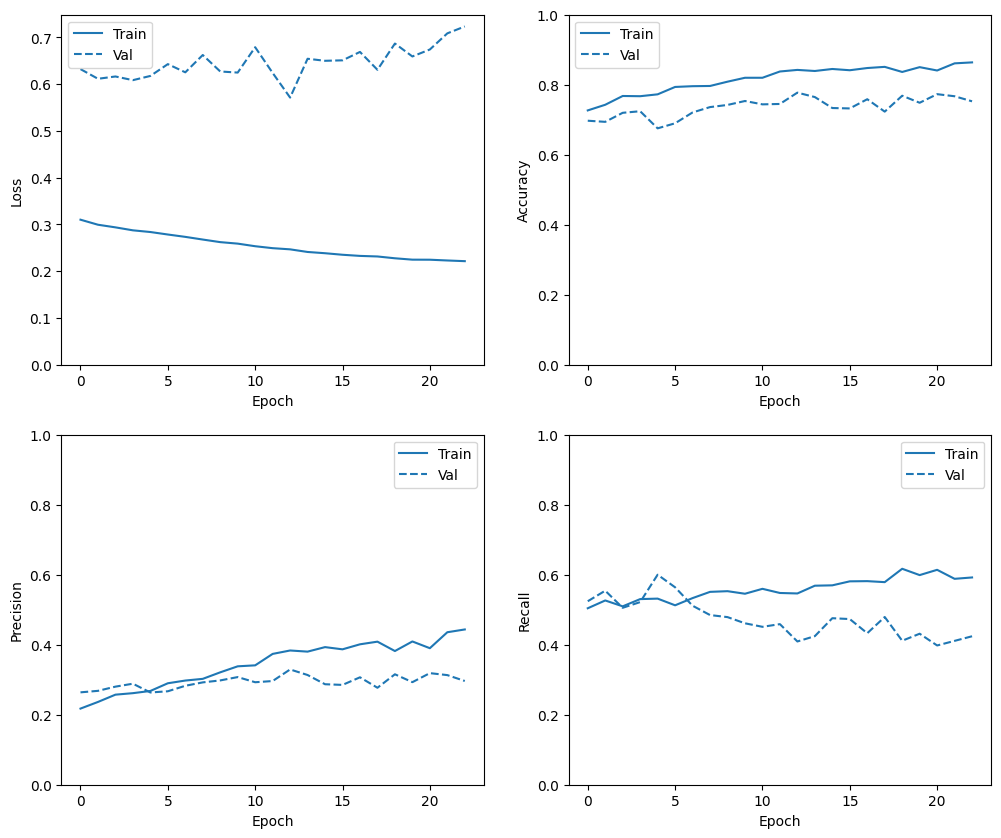

In [32]:
if model_type == 'classifier':
    plot_metrics(history)

In [33]:
model.evaluate(X_test_sequences, y_test_sequences)

1259/1259 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8433 - loss: 0.5127 - precision: 0.2430 - recall: 0.3271


[0.5436060428619385,
 0.8076397776603699,
 0.3003371059894562,
 0.38139715790748596]

In [34]:
tar_pct = round((y_train_sequences.sum() / y_train_sequences.shape)[0],4)
tar_pct

0.126

In [35]:
round(np.mean(history.history.get('val_precision')),4)

0.2929

In [36]:
file_name = f"{datetime.datetime.now()}_RNN_{model_type}_{quarters_input}_qtr_{threshold}_ths_sc_{small_cap}.pkl"
model_dir = '../models/'
file_name

'2024-09-10 23:32:00.858181_RNN_classifier_4_qtr_0.5_ths_sc_True.pkl'

In [37]:
# Export Pipeline as pickle file
with open(model_dir+file_name, "wb") as file:
    pickle.dump(model, file)

In [637]:
#model = pickle.load(open(model_dir+file_name,"rb"))